In [36]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from imutils import face_utils
font = cv2.FONT_HERSHEY_SIMPLEX

In [37]:
import os

def get_files(path):
    return os.listdir(path)

cascPath = "/Users/telekenesis/Husky Gdrive/Coursework/7. SML_EE/Project/image/haarcascade_frontalface_default.xml"

def return_bbx(image):
    faceCascade = cv2.CascadeClassifier(cascPath)
    faces = faceCascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, flags=cv2.CASCADE_SCALE_IMAGE)
    return faces

In [38]:
Dataset_path = '/Users/telekenesis/Husky Gdrive/Coursework/7. SML_EE/Project/Data/'

Celebs = pd.read_csv('/Users/telekenesis/Husky Gdrive/Coursework/7. SML_EE/Project/lfw_allnames.csv')
Celebs = Celebs[Celebs['images']>50]
Celebs

,name,images
373,Ariel_Sharon,77
1047,Colin_Powell,236
1404,Donald_Rumsfeld,121
1871,George_W_Bush,530
1892,Gerhard_Schroeder,109
2175,Hugo_Chavez,71
2288,Jacques_Chirac,52
2468,Jean_Chretien,55
2682,John_Ashcroft,53
2941,Junichiro_Koizumi,60


In [39]:
X = []
Y = []

for _, [name,__] in Celebs.iterrows():
    celeb_path = Dataset_path+name+'/'
    
    images_paths = get_files(celeb_path)
    for image_path in images_paths:
        image = cv2.imread(celeb_path+image_path,1)
        faces = return_bbx(image)
        if len(faces) == 1:
            (x,y,w,h) = faces[0]
            cropped = image[x:x+w, y:y+h]
            dim = (64, 64)
            resized = cv2.resize(cropped, dim, interpolation = cv2.INTER_AREA)
            image = np.array(resized).astype("float32")
            X.append(image)
            Y.append(name)



In [40]:
X_data = np.array(X)
Y_data = np.array(Y)

In [41]:
from collections import Counter


In [42]:
Counter(Y_data)

Counter({'Ariel_Sharon': 70,
         'Colin_Powell': 214,
         'Donald_Rumsfeld': 109,
         'George_W_Bush': 480,
         'Gerhard_Schroeder': 106,
         'Hugo_Chavez': 67,
         'Jacques_Chirac': 51,
         'Jean_Chretien': 51,
         'John_Ashcroft': 47,
         'Junichiro_Koizumi': 51,
         'Serena_Williams': 48,
         'Tony_Blair': 138})

In [43]:
from imblearn.under_sampling import NearMiss

X_data_reshaped = X_data.reshape(X_data.shape[0], X_data.shape[1] * X_data.shape[2] * X_data.shape[3])
undersample = NearMiss(version=1)
X_resampled, Y_resampled = undersample.fit_resample(X_data_reshaped,Y_data)
# X_data = X_resampled.reshape(X_resampled.shape[0], X_data.shape[1], X_data.shape[2], X_data.shape[3])
Y_data = Y_resampled
counter = Counter(Y_data)
print(counter)

del X_data_reshaped
del undersample
# del X_resampled
del Y_resampled
del counter

Counter({'Ariel_Sharon': 47, 'Colin_Powell': 47, 'Donald_Rumsfeld': 47, 'George_W_Bush': 47, 'Gerhard_Schroeder': 47, 'Hugo_Chavez': 47, 'Jacques_Chirac': 47, 'Jean_Chretien': 47, 'John_Ashcroft': 47, 'Junichiro_Koizumi': 47, 'Serena_Williams': 47, 'Tony_Blair': 47})


In [44]:
a = Y_data
n_classes = len(set(a))
n_classes

12

In [131]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder

scaler = MinMaxScaler(feature_range=(0, 1))
X_resampled = scaler.fit_transform(X_resampled)
X_data = X_resampled.reshape(X_resampled.shape[0], X_data.shape[1],
                             X_data.shape[2], X_data.shape[3])


In [132]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=0.9, random_state = 0)


In [133]:
from tensorflow.python.keras.applications import VGG16
rows = dim[0]
cols = dim[1]

num_classes = n_classes

In [134]:
for (i,layer) in enumerate(model.layers):
    print(str(i) + " " + layer.__class__.__name__,layer.trainable)

0 Conv2D True
1 LeakyReLU True
2 MaxPooling2D True
3 Conv2D True
4 LeakyReLU True
5 MaxPooling2D True
6 Conv2D True
7 LeakyReLU True
8 MaxPooling2D True
9 Flatten True
10 Dense True
11 Dropout True
12 Dense True
13 Dropout True
14 LeakyReLU True
15 Dense True


In [135]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten,GlobalAveragePooling2D
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.regularizers import l2


model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), input_shape=(rows,cols,3), padding = 'same'))

# model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2,2),padding='valid'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='valid',
                 kernel_regularizer = l2(0.01)))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='valid',
                 kernel_regularizer = l2(0.01)))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1028, activation='relu'))
# model.add(Dropout(0.5))
model.add(LeakyReLU(alpha=0.01))                  
model.add(Dense(num_classes, activation='softmax'))



In [136]:
# model.input

In [137]:
# model.layers

In [138]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten,GlobalAveragePooling2D
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.models import Model


num_classes = n_classes

# print(model.summary())

In [139]:
from tensorflow.python.keras.utils import to_categorical

def oneHotEncode(y_data):
    mapping = {}
    unique = list(set(y_data))
    integ = []
    for i in range(0,len(unique)):
        mapping[unique[i]] = i

    for x in range(len(y_data)):
        integ.append(mapping[y_data[x]])
    onehot = to_categorical(integ)
    return onehot,mapping

y_train_ohe,map_train = oneHotEncode(y_train)
y_test_ohe,map_test = oneHotEncode(y_test)


In [ ]:
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint = ModelCheckpoint("face_recog_vgg.h5", monitor="val_loss", mode = "min", save_best_only = True, verbose = 1)
# earlystop = EarlyStopping(monitor= 'val_loss', min_delta=0, patience=3, verbose=1,
#                           restore_best_weights=True
#                          )
# callbacks = [earlystop, checkpoint]

model.compile(loss="categorical_crossentropy", 
              optimizer="adam",
              metrics=['accuracy'])

epochs=50
batch_size=64

history = model.fit(X_train,
                    y_train_ohe,
                    validation_data = (X_test,
                                       y_test_ohe),
                    verbose = 1,                    
                    epochs = epochs,
                    batch_size = batch_size)

model.save('fgvgg.h5')


Train on 507 samples, validate on 57 samples
Epoch 1/50
507/507 [==============================] - 7s 14ms/step - loss: 3.8538 - acc: 0.0947 - val_loss: 3.6154 - val_acc: 0.1053
Epoch 2/50
507/507 [==============================] - 5s 9ms/step - loss: 3.4488 - acc: 0.1302 - val_loss: 3.1947 - val_acc: 0.1754
Epoch 3/50
507/507 [==============================] - 5s 9ms/step - loss: 3.0989 - acc: 0.1953 - val_loss: 2.9440 - val_acc: 0.1404
Epoch 4/50
507/507 [==============================] - 4s 9ms/step - loss: 2.8252 - acc: 0.2130 - val_loss: 2.7832 - val_acc: 0.2281
Epoch 5/50
507/507 [==============================] - 4s 8ms/step - loss: 2.5187 - acc: 0.3097 - val_loss: 2.6463 - val_acc: 0.3158
Epoch 6/50
507/507 [==============================] - 4s 8ms/step - loss: 2.3240 - acc: 0.3866 - val_loss: 2.4598 - val_acc: 0.3158
Epoch 7/50
507/507 [==============================] - 4s 8ms/step - loss: 1.9252 - acc: 0.5010 - val_loss: 2.1918 - val_acc: 0.3684
Epoch 8/50
507/507 [==========

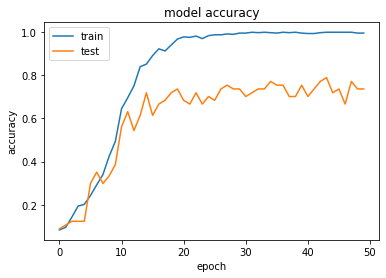

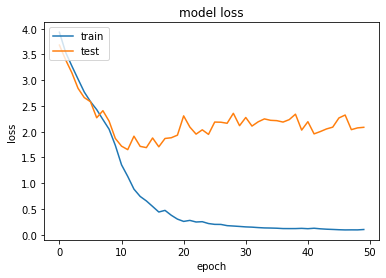

In [96]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [89]:

from tensorflow.python.keras.models import load_model
classifier = load_model('fgvgg.h5')


In [90]:
import os 
import cv2
import numpy as np
from os import listdir

In [16]:
input_im = X_test
res = np.argmax(classifier.predict(input_im, 1, verbose=0), axis = 1)

# draw_test("Prediction", res, input_im)
# cv2.waitkey(5000)
# cv2.destroyAllWindows()

res
                

NameError: name 'classifier' is not defined

In [104]:

uni = list(set(a))
[uni[item] for item in res]

['Serena_Williams',
 'Gerhard_Schroeder',
 'Serena_Williams',
 'Serena_Williams',
 'Gerhard_Schroeder',
 'John_Ashcroft',
 'Gerhard_Schroeder',
 'Gerhard_Schroeder',
 'Jean_Chretien',
 'Ariel_Sharon',
 'Serena_Williams',
 'John_Ashcroft',
 'Jean_Chretien',
 'John_Ashcroft',
 'Serena_Williams',
 'Serena_Williams',
 'Serena_Williams',
 'John_Ashcroft',
 'Tony_Blair',
 'Ariel_Sharon',
 'Junichiro_Koizumi',
 'Serena_Williams',
 'Serena_Williams',
 'Serena_Williams',
 'Donald_Rumsfeld',
 'Gerhard_Schroeder',
 'Junichiro_Koizumi',
 'Jean_Chretien',
 'Donald_Rumsfeld',
 'Donald_Rumsfeld',
 'Serena_Williams',
 'Serena_Williams',
 'Serena_Williams',
 'Ariel_Sharon',
 'Serena_Williams',
 'Colin_Powell',
 'Serena_Williams',
 'Gerhard_Schroeder',
 'Gerhard_Schroeder',
 'Junichiro_Koizumi',
 'Serena_Williams',
 'Serena_Williams',
 'John_Ashcroft',
 'Serena_Williams',
 'Donald_Rumsfeld',
 'Serena_Williams',
 'Ariel_Sharon',
 'Donald_Rumsfeld',
 'Serena_Williams',
 'Ariel_Sharon',
 'Gerhard_Schroeder

In [103]:
len(list(set(a)))

12

[<1x12 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <1x12 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <1x12 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <1x12 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <1x12 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <1x12 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <1x12 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <1x12 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <1x12 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compr

In [71]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [72]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [58]:
trainloader = list(zip(X_train,y_train))
y_train

array(['Donald_Rumsfeld', 'Ariel_Sharon', 'John_Ashcroft',
       'Jean_Chretien', 'Colin_Powell', 'Hugo_Chavez', 'John_Ashcroft',
       'Ariel_Sharon', 'Junichiro_Koizumi', 'Tony_Blair', 'Hugo_Chavez',
       'Hugo_Chavez', 'Tony_Blair', 'Jacques_Chirac', 'George_W_Bush',
       'Serena_Williams', 'Junichiro_Koizumi', 'Ariel_Sharon',
       'Donald_Rumsfeld', 'George_W_Bush', 'Ariel_Sharon',
       'John_Ashcroft', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder',
       'Donald_Rumsfeld', 'Colin_Powell', 'John_Ashcroft', 'Colin_Powell',
       'Jean_Chretien', 'Colin_Powell', 'Serena_Williams', 'Tony_Blair',
       'Tony_Blair', 'John_Ashcroft', 'John_Ashcroft', 'Jacques_Chirac',
       'Jean_Chretien', 'Gerhard_Schroeder', 'Donald_Rumsfeld',
       'John_Ashcroft', 'George_W_Bush', 'John_Ashcroft', 'John_Ashcroft',
       'Hugo_Chavez', 'Jean_Chretien', 'Serena_Williams', 'George_W_Bush',
       'Serena_Williams', 'Tony_Blair', 'Tony_Blair', 'George_W_Bush',
       'Serena_Williams'

In [18]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [59]:
to_categorical(list(y_train))

ValueError: invalid literal for int() with base 10: 'Donald_Rumsfeld'

In [83]:
y_train_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)